## Extended Project Supplement
Interactive plots + animations corresponding to figures
- Code for all figures??
- Numerical Methods 
- Application to model
- Space homogeneity
- Space inhomogeneity
- Python .py file too?


In [5]:
import numpy as np
from numpy.random import normal, uniform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.color_palette('colorblind')

from FinalCode import plotting_tools as animplt
from FinalCode  import herding as herd
from FinalCode import ToyProblems as TP

## Toy Problems

- Heat eqn, adv eqn
- Mesh refinement error
- OU particles

Solving the heat equation using finite differences. To see the sensitivity of FTCS on mesh size, try violating the stability condition $\frac{\sigma \Delta t}{\Delta x}^2 < \frac{1}{2}$. For example, set `diffusion = 1, timestep = 0.01, spacestep = 0.1`

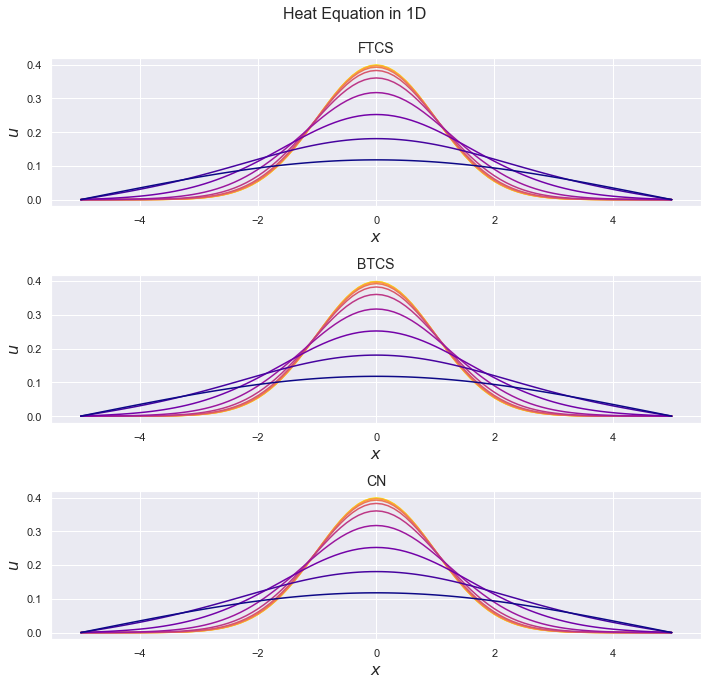

In [28]:
diffusion = 1
timestep = 0.001
spacestep = 0.1
T_final = 5
domain_size = 5

diff_solvers = [TP.FTCS, TP.BTCS, TP.CN]

###############################################################################
cmap = plt.get_cmap('plasma')
fig, ax = plt.subplots(len(diff_solvers), 1, figsize=(10,10))
fig.suptitle('Heat Equation in 1D', fontsize=16)
if len(diff_solvers)>1:
    for idx, solver in enumerate(diff_solvers):
        x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                                T_end=T_final, L=domain_size)
        ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
        ax[idx].set_title(solver.__name__, fontsize=14)
        ax[idx].set_xlabel(r'$x$', fontsize=16)
        ax[idx].set_ylabel(r'$u$', fontsize=16)
        for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
            ax[idx].plot(x, sol[int(i),])
else:
    solver = diff_solvers[0]
    x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                            T_end=T_final, L=domain_size)
    ax.set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    ax.set_title(solver.__name__, fontsize=14)
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.set_ylabel(r'$u$', fontsize=16)
    for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
        ax.plot(x, sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])



### Mesh Refinement error

The finite difference codes are tested by solving the heat equation with boundary
conditions φ(0, t) = φ(L, t) = 0, and initial condition f0(x) = sin (πx/L). The
exact solution for this problem (which is derived in Appendix B) is
φ(x, t) = sin πx
L

exp 
−
απ2
t
L2



In [30]:
diffusion = 1
timestep = np.logspace(0, -6, num=7)
print(timestep)
spacestep = 0.1
T_final = 5
domain_size = 5

diff_solvers = [TP.FTCS, TP.BTCS, TP.CN]

fig, ax = plt.subplots(len(diff_solvers), 1, figsize=(10,10))
fig.suptitle('Error as Mesh is Refined', fontsize=16)
if len(diff_solvers)>1:
    for idx, solver in enumerate(diff_solvers):
        x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                                T_end=T_final, L=domain_size)
        ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
        ax[idx].set_title(solver.__name__, fontsize=14)
        ax[idx].set_xlabel(r'$x$', fontsize=16)
        ax[idx].set_ylabel(r'$u$', fontsize=16)
        for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
            ax[idx].plot(x, sol[int(i),])
else:
    solver = diff_solvers[0]
    x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                            T_end=T_final, L=domain_size)
    ax.set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    ax.set_title(solver.__name__, fontsize=14)
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.set_ylabel(r'$u$', fontsize=16)
    for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
        ax.plot(x, sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06]


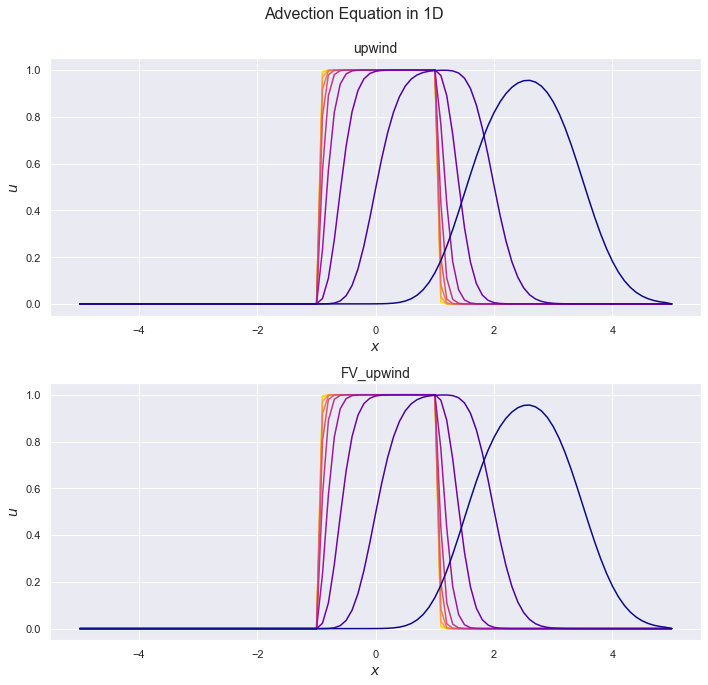

In [16]:
wavespeed = 0.5
T_final = 5
timestep = 0.001
spacestep = 0.1
domain_size = 5

adv_solvers = [TP.upwind, TP.FV_upwind]


###############################################################################
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig.suptitle('Advection Equation in 1D', fontsize=16)
cmap = plt.get_cmap('plasma')
if len(adv_solvers)>1:
    for idx, solver in enumerate(adv_solvers):
        adv_x, adv_sol = TP.solve_adv_eqn(solver=solver, a=wavespeed,
                                          dt=timestep, dx=spacestep,
                                          T_end=T_final, L=domain_size)
        ax[idx].set_title(solver.__name__, fontsize=14)
        ax[idx].set_xlabel(r'$x$', fontsize=14)
        ax[idx].set_ylabel(r'$u$', fontsize=14)
        ax[idx].set_prop_cycle(color=[cmap(k) for k in np.linspace(1, 0, 10)])
        for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
            ax[idx].plot(adv_x, adv_sol[int(i),])
else:
    solver = adv_solvers[0]
    adv_x, adv_sol = TP.solve_adv_eqn(solver=solver, a=wavespeed, T_end=T_final)
    ax.set_title(solver.__name__, fontsize=14)
    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_ylabel(r'$u$', fontsize=14)
    ax.set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax.plot(adv_x, adv_sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Particle Model Simulation

Interaction, histograms 

switch! In space?


## PDE Simulation
- FD
- Space hom show agreement with particle model in histogram
- Exponential Convergence of moments
- Long time L1 error, asymmetry
- FV method
- agreement in histogram, visual with FD
- symmetric error
- Mesh refinement errors
- 


## Space Het Particle Model
Visual switch